Here’s the same “explain-like-I’m-5-but-useful” tour 👇

# What is Thompson Sampling (TS)?

A strategy for choosing between options **while learning**.
Rule of thumb: **“Pretend each option has a hidden success rate. Keep a belief (distribution) about each one. Sample a guess from each belief and pick the option with the biggest sampled guess.”**
This naturally balances **exploration** (try uncertain options) and **exploitation** (pick the best-looking).

Nickname: **probability matching** — you pick each option roughly as often as the chance it’s actually the best.

---

# Shop example (click/no-click banners)

You have 3 homepage banners: **A, B, C**.
Each visit you show one banner and observe a **reward**: click=1, no click=0.
We’ll model “click probability” of each banner with a **Beta** distribution and update it as we see outcomes.

## Why Beta?

For **Bernoulli** (0/1) rewards, **Beta** is the conjugate prior.

* Prior: $$(\theta \sim \text{Beta}(\alpha,\beta))$$
* After seeing **s** clicks and **f** no-clicks:
  $$(\theta \mid \text{data} \sim \text{Beta}(\alpha+s,; \beta+f))$$

Interpretation: $$(\alpha-1) = prior “successes,” (\beta-1) = prior “failures.”$$
A common neutral start is **Beta(1,1)** (uniform).

---

# Thompson Sampling (Beta–Bernoulli) — step by step

**Initialize** (for A, B, C):

* $$((\alpha,\beta) = (1,1)) for-each-banner (no-knowledge-yet).$$

For each round (t=1,2,3,\dots):

1. **Sample a guess** of click-rate for each banner:
  $$ (\hat\theta_A \sim \text{Beta}(\alpha_A,\beta_A)), same for B, C.$$
2. **Pick** the banner with the largest sampled (\hat\theta).
3. **Show** it, observe reward (r \in {0,1}).
4. **Update** that banner’s Beta:

   * if click (1): $$(\alpha \leftarrow \alpha + 1)$$
   * if no-click (0): $$(\beta \leftarrow \beta + 1)$$
     (others stay unchanged)
5. Repeat.

### Tiny walk-through (just a few rounds)

Start: all Beta(1,1). Samples are random in (0,1).

* **Round 1**: suppose samples were A=0.64, B=0.21, C=0.77 → pick **C**.
  User **clicks** → C: (α,β) goes (1,1)→(2,1).
* **Round 2**: sample again, say A=0.48, B=0.58, C=0.66 → pick **C**.
  User **no-click** → C: (2,1)→(2,2).
* **Round 3**: sample A=0.71, B=0.13, C=0.49 → pick **A**.
  User **clicks** → A: (1,1)→(2,1).
* …and so on.

What happens: options with **better** observed performance tend to **win the sampling** more often, but **uncertain** options (with wide Beta) still get chances.

---

# Why TS works (intuition)

* If you’re **uncertain**, your Beta is **wide**; sometimes it samples high → you **explore**.
* As evidence accumulates, Betas **narrow**; the truly good option samples high more often → you **exploit**.
* No manual “exploration rate” to tune — it’s built into the math.

---

# Pseudocode (Bernoulli rewards)

```
for each arm i:
    alpha[i] = 1; beta[i] = 1   # prior

for t in 1..T:
    for each arm i:
        theta_sample[i] = sample_from_Beta(alpha[i], beta[i])
    a = argmax_i theta_sample[i]
    r = pull(a)                 # 0 or 1
    if r == 1: alpha[a] += 1
    else:      beta[a]  += 1
```

---

# Minimal Python (simulation-ready)

```python
import random
import math
from random import betavariate

def thompson_sampling_bernoulli(arms, T, seed=42):
    """
    arms: list of functions that return 0/1 reward (e.g., lambda: random.random() < 0.12)
    T:    number of rounds
    """
    random.seed(seed)
    K = len(arms)
    alpha = [1.0]*K  # successes + prior
    beta = [1.0]*K   # failures  + prior
    pulls = [0]*K
    clicks = [0]*K

    for t in range(1, T+1):
        # 1) sample one theta per arm
        samples = [betavariate(alpha[i], beta[i]) for i in range(K)]
        # 2) pick the arm with the largest sample
        a = max(range(K), key=lambda i: samples[i])
        # 3) observe reward
        r = arms[a]()
        # 4) update alpha/beta
        if r == 1:
            alpha[a] += 1
            clicks[a] += 1
        else:
            beta[a] += 1
        pulls[a] += 1

    estimates = [alpha[i] / (alpha[i] + beta[i]) for i in range(K)]
    return pulls, clicks, estimates, list(zip(alpha, beta))

# Example “true CTRs” for A,B,C:
arms = [
    lambda: 1 if random.random() < 0.08 else 0,  # A 8%
    lambda: 1 if random.random() < 0.05 else 0,  # B 5%
    lambda: 1 if random.random() < 0.12 else 0,  # C 12% (best)
]

pulls, clicks, est, post = thompson_sampling_bernoulli(arms, T=5000)
print("Pull counts:", pulls)
print("Clicks:", clicks)
print("Posterior means:", [round(x,4) for x in est])
print("Posteriors (alpha,beta):", post)
```

You should see the best arm (C) pulled the most, with posterior means close to true CTRs.

---

# When & how to use TS (practical)

**Great for:**

* **Online A/B/n** choices with immediate feedback (click, signup, purchase).
* **Stationary** environments (probabilities don’t drift fast).
* Situations where you have **prior beliefs** (e.g., past launches) — set ((\alpha_0,\beta_0)) accordingly.

**Setup checklist:**

1. Define **arms** (variants).
2. Define **reward** in **[0,1]** (click=1/no=0; or scale profit by a safe max).
3. Start with **Beta(1,1)** (neutral) or informative priors (e.g., Beta(2,20) ≈ 9% prior CTR).
4. Run TS online; log arm, reward, and time.
5. Track cumulative reward and per-arm posteriors.

---

# Variants beyond Bernoulli

* **Gaussian rewards** (e.g., revenue with known variance (\sigma^2)):

  * Prior on mean: $$(\mu \sim \mathcal{N}(\mu_0, \tau_0^2))$$.
  * Posterior is normal; each round, **sample (\tilde{\mu}_i)** from the posterior of each arm’s mean and pick the max.
  * If variance unknown, use Normal–Inverse-Gamma (posterior sampling yields a Student-t for the mean).

* **Poisson counts** (e.g., #items sold):

  * Gamma–Poisson: $$(\lambda \sim \text{Gamma}(a,b))$$; observe counts; posterior remains Gamma; **sample (\tilde{\lambda})** and pick max.

* **Categorical outcomes** with multiple categories:

  * Dirichlet–Multinomial: $$(\boldsymbol{p} \sim \text{Dirichlet}(\boldsymbol{\alpha}))$$; sample $$(\tilde{\boldsymbol{p}})$$; choose action by expected utility.

* **Contextual TS (LinTS):** the best option depends on **features** (user/device/time).

  * Model reward as linear in features: $$(r \sim \mathcal{N}(x^\top \theta, \sigma^2))$$ with Bayesian linear regression.
  * Each round, sample $$(\tilde{\theta})$$ from its posterior, pick arm with highest $$(x^\top \tilde{\theta})$$.

---

# Thompson Sampling vs. UCB (quick compare)

| Aspect           | Thompson Sampling                            | UCB (e.g., UCB1)                                       |
| ---------------- | -------------------------------------------- | ------------------------------------------------------ |
| Tuning           | Little to none (priors)                      | Needs exploration coefficient choices in some variants |
| Philosophy       | Sample from belief; **probability matching** | **Optimism**: mean + bonus                             |
| Priors           | Natural place to inject prior knowledge      | Not really                                             |
| Behavior         | Often very strong in practice                | Strong, deterministic, simple                          |
| Non-stationarity | Use **discounting** or **sliding windows**   | Use windowed/discounted UCB                            |

Both are great; TS often edges out with fewer parameters to fuss over.

---

# Practical tips & guardrails

* **Priors matter:** Neutral (=) Beta(1,1). If you expect ~5% CTR, Beta(1,19) is a light prior; stronger belief? scale up (e.g., Beta(5,95)).
* **Cold start:** TS copes well, but ensure each arm gets at least a handful of trials early (TS naturally does).
* **Delayed rewards:** queue updates once the outcome arrives; until then, the arm’s belief stays wider → more exploration.
* **Non-stationary:** apply **decay** (e.g., every hour: (\alpha\leftarrow \lambda \alpha), (\beta\leftarrow \lambda \beta) with (\lambda \in [0.95,0.999])) or use **sliding windows**.
* **Reward scaling:** keep rewards in ([0,1]). For money, divide by a safe max or use a Gaussian/Poisson model.
* **Traffic constraints:** if you must guarantee each variant gets X% traffic, mix TS with a small **floor allocation**.
* **Segmenting:** if behavior differs by country/device, run **separate** bandits or use **contextual TS**.

---

# One-liner intuition

“Keep a belief about each option’s success rate, **draw a sample** from each belief, and pick the option with the **highest draw**. Update beliefs with outcomes, repeat.”

If you want, I can spin up a tiny notebook that compares **Thompson Sampling vs UCB vs ε-greedy** on your actual variants and plot cumulative clicks/regret.


# Thompson Sampling

## Importing the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Importing the dataset

In [0]:
dataset = pd.read_csv('Ads_CTR_Optimisation.csv')

## Implementing Thompson Sampling

In [0]:
import random
N = 10000
d = 10
ads_selected = []
numbers_of_rewards_1 = [0] * d
numbers_of_rewards_0 = [0] * d
total_reward = 0
for n in range(0, N):
    ad = 0
    max_random = 0
    for i in range(0, d):
        random_beta = random.betavariate(numbers_of_rewards_1[i] + 1, numbers_of_rewards_0[i] + 1)
        if random_beta > max_random:
            max_random = random_beta
            ad = i
    ads_selected.append(ad)
    reward = dataset.values[n, ad]
    if reward == 1:
        numbers_of_rewards_1[ad] = numbers_of_rewards_1[ad] + 1
    else:
        numbers_of_rewards_0[ad] = numbers_of_rewards_0[ad] + 1
    total_reward = total_reward + reward

## Visualising the results - Histogram

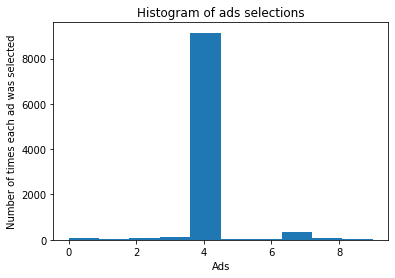

In [4]:
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()